# Apriori algorithm using Spark RDDs
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2019`__

This exercise is based on Chapter 6 in Mining of Massive Data Sets by Jure Leskovec, Anand Rajaraman, and Jeffrey D. Ullman    
*(Credit for sections 2-5 goes to Elle Proust, w261 Spring 2019)*    

## 1. Introduction
* Read Chapter 6 in MMDS.   
* Please list other sources you've found helpful in completing this assignment.

### Summary of Chapter 6, pg.236
* __Market-Basket Data__: This model of data assumes there are two kinds of
entities: items and baskets. There is a many–many relationship between
items and baskets. Typically, baskets are related to small sets of items,
while items may be related to many baskets.
* __Frequent Itemsets__: The support for a set of items is the number of baskets
containing all those items. Itemsets with support that is at least some
threshold are called frequent itemsets.
* __Association Rules__: These are implications that if a basket contains a
certain set of items I, then it is likely to contain another particular item
j as well. The probability that j is also in a basket containing I is called
the confidence of the rule. The interest of the rule is the amount by which
the confidence deviates from the fraction of all baskets that contain j.

<img src="Frequent-itemsets.png">

## Notebook setup

In [18]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import tarfile
import itertools

In [19]:
%reload_ext autoreload
%autoreload 2

In [20]:
PWD = !pwd
PWD = PWD[0]

In [21]:
from pyspark.sql import SparkSession
app_name = "Apriori"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

*(Credit for this section goes to Elle Proust, w261 Spring 2019)*    

## 2. Toy data set
* Each row represents a transaction
* Each column represents an item
* A `1` indicates whether an item was purchased in that transaction. 

The 'support' for an individual item is the number of times it has been purchased - the sum of the column. 

In [5]:
toy = pd.read_csv('basket-toy.csv', sep =',', index_col = 0)
toy

,chocolate,bread,coffee,wine,diamonds
transactionID,,,,,
1,1,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,1
4,1,1,1,0,0
5,0,1,0,0,0
6,1,0,0,0,0
7,0,0,1,0,0
8,0,0,0,1,1
9,1,0,1,0,0


Support for each - item - essentially we need to know how many times it is bought:

In [6]:
toy.sum(axis = 0)

chocolate    4
bread        3
coffee       5
wine         3
diamonds     2
dtype: int64

To get the co-occurence - we can just multiply the transactition matrix by its transpose.    
* On the diagonal we have the support of the item.
* The rest of the cells give us the frequencies of the item pairs.

In [9]:
coocc = toy.T.dot(toy)
coocc

,chocolate,bread,coffee,wine,diamonds
chocolate,4,2,2,0,0
bread,2,3,1,0,0
coffee,2,1,5,1,0
wine,0,0,1,3,2
diamonds,0,0,0,2,2


We can see that our most popular pair combinations are __diamonds and wine__, and __chocolate with bread or coffee__ .    
Computing things this way would result in a mostly sparse matrix, and would not be scalable if we had many orders of magnitude more transactions and product types. 


## 3. Data & EDA

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 24th of March 2019.       
The data dictionary is available at: https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b   

This anonymized dataset contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The data-set we will use to implement apriori is the order_products set which contains an item for each time a product was ordered, and an ordered ID, allowng us to see what items were purchased in the same transaction. 

We will also us the products data file to be able to look up which items appear most frequently. 

## __TASKS__:
Run the cells in this section and make sure you understand each step.

In [11]:
!mkdir apriori_data
!wget -O apriori_data/zipped-data.tar.gz https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz

--2019-10-19 18:51:17--  https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz
Resolving s3.amazonaws.com... 52.216.129.109
Connecting to s3.amazonaws.com|52.216.129.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205548478 (196M) [application/x-gzip]
Saving to: `apriori_data/zipped-data.tar.gz'

100%[======================================>] 205,548,478 10.6M/s   in 20s     

2019-10-19 18:51:38 (9.67 MB/s) - `apriori_data/zipped-data.tar.gz' saved [205548478/205548478]



In [15]:
!tar -xzvf apriori_data/zipped-data.tar.gz -C apriori_data

instacart_2017_05_01/
instacart_2017_05_01/._aisles.csv
instacart_2017_05_01/aisles.csv
instacart_2017_05_01/._departments.csv
instacart_2017_05_01/departments.csv
instacart_2017_05_01/._order_products__prior.csv
instacart_2017_05_01/order_products__prior.csv
instacart_2017_05_01/._order_products__train.csv
instacart_2017_05_01/order_products__train.csv
instacart_2017_05_01/._orders.csv
instacart_2017_05_01/orders.csv
instacart_2017_05_01/._products.csv
instacart_2017_05_01/products.csv


In [16]:
## view data
!head -n 10 apriori_data/instacart_2017_05_01/order_products__train.csv

order_id,product_id,add_to_cart_order,reordered
1,49302,1,1
1,11109,2,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0
1,47209,7,0
1,22035,8,1
36,39612,1,0


In [23]:
##remove data header and remove extraneous data

header = !head -n 1 apriori_data/order_products__train.csv
header = header[0]
FIELDS =  re.sub('"', '', header).split(',')

## map tuples with (Order Id, Product_ID)
trainRDD = sc.textFile('apriori_data/instacart_2017_05_01/order_products__train.csv')\
            .filter(lambda x: x != header)\
            .map(lambda x: (x.split(',')[0], [x.split(',')[1]])).cache()

priorRDD = sc.textFile('apriori_data/instacart_2017_05_01/order_products__prior.csv')\
            .filter(lambda x: x != header)\
            .map(lambda x: (x.split(',')[0], [x.split(',')[1]])).cache()

fullRDD= priorRDD.union(trainRDD)

## group products by order key 
practiceRDD = trainRDD.reduceByKey(lambda x, y: x+y).cache()

orderRDD = fullRDD.reduceByKey(lambda x, y: x+y).cache()

## Count number of orders and average length
print("There are",orderRDD.count(),"orders")

average_len = orderRDD.map(lambda x: len(x[1])).mean()
print("Each item is purc order is: average length",average_len)

There are 3346084 orders
Each item is purc order is: average length 10.107070832650926


We will conduct the rest of the exploratory analysis primarily on the smaller train data set.


total individual item purchased 1384618
unique prods in set 39124
mean purchase 35.39050199366118
max ordered 18726


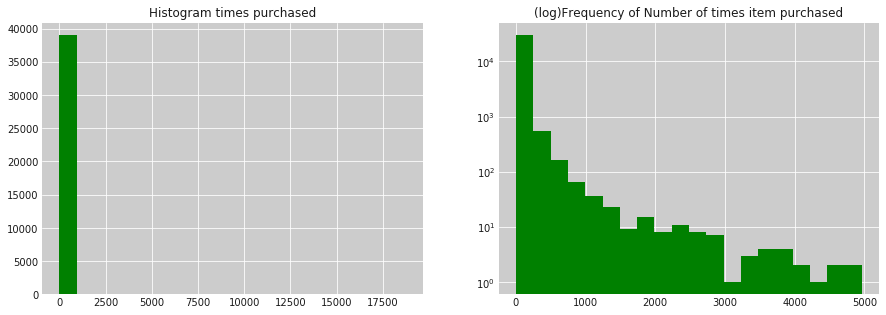

In [24]:
total_items=trainRDD.count()
print("total individual item purchased",total_items)
##map by product to order, so product is key, and then 
inverted_index=trainRDD.map(lambda x : (x[1][0], [x[0]])).reduceByKey(lambda x,y:x+y).cache()
print("unique prods in set",inverted_index.count())
prod_count=inverted_index.map(lambda x: len(x[1])).collect()
prod_count_1=inverted_index.map(lambda x: len(x[1])).filter(lambda x: x > 1 and x <5000).collect()
print("mean purchase",total_items/inverted_index.count())
print("max ordered",max(prod_count))

# set up figure
fig, (ax1, ax4) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(prod_count, bins=20, color = 'green')
ax1.set_title('Histogram times purchased', color='0.1')
ax1.set_facecolor('0.8')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)


# plot log scale hist
ax4.hist(prod_count_1, bins=20, color = 'green')
ax4.set_title('(log)Frequency of Number of times item purchased', color='0.1')
ax4.set_facecolor('0.8')
ax4.tick_params(axis='both', colors='0.1')
ax4.grid(True)
plt.yscale('log')


plt.show()

We can see most items are purchased very few times, there are only 1000 or so items purchased even a hundred times times.

## What are the most common Purchases?

In [35]:
#practice data
initsupportRDD = trainRDD.map(lambda x : (x[1][0], 1)).reduceByKey(lambda x,y:x+y).cache()
print(initsupportRDD.count(),' individual products appear in the test data')

header_prod = !head -n 1 apriori_data/instacart_2017_05_01/order_products__train.csv

prodRDD = sc.textFile('apriori_data/instacart_2017_05_01/products.csv')\
            .filter(lambda x: x != header_prod)\
            .map(lambda x: (x.split(',')[0], x.split(',')[1]))

prodRDD.join(initsupportRDD).map(lambda x: (x[1][0], x[1][1])).takeOrdered(20, key=lambda x: - x[1])

39124  individual products appear in the test data


[('Banana', 18726),
 ('Bag of Organic Bananas', 15480),
 ('Organic Strawberries', 10894),
 ('Organic Baby Spinach', 9784),
 ('Large Lemon', 8135),
 ('Organic Avocado', 7409),
 ('Organic Hass Avocado', 7293),
 ('Strawberries', 6494),
 ('Limes', 6033),
 ('Organic Raspberries', 5546),
 ('Organic Blueberries', 4966),
 ('Organic Whole Milk', 4908),
 ('Organic Cucumber', 4613),
 ('Organic Zucchini', 4589),
 ('Organic Yellow Onion', 4290),
 ('Organic Garlic', 4158),
 ('Seedless Red Grapes', 4059),
 ('Asparagus', 3868),
 ('Organic Grape Tomatoes', 3823),
 ('Organic Red Onion', 3818)]

In [36]:
## count orders by product
initsupportRDD = fullRDD.map(lambda x : (x[1][0], 1)).reduceByKey(lambda x,y:x+y).cache()
print(initsupportRDD.count(),' individual products appear in the full data')

header_prod = !head -n 1 apriori_data/instacart_2017_05_01/products.csv

## load product names
prodRDD = sc.textFile('apriori_data/instacart_2017_05_01/products.csv')\
            .filter(lambda x: x != header_prod)\
            .map(lambda x: (x.split(',')[0], x.split(',')[1]))

#map to product names
prodRDD.join(initsupportRDD).map(lambda x: (x[1][0], x[1][1])).takeOrdered(20, key=lambda x: - x[1])

49686  individual products appear in the full data


[('Banana', 491291),
 ('Bag of Organic Bananas', 394930),
 ('Organic Strawberries', 275577),
 ('Organic Baby Spinach', 251705),
 ('Organic Hass Avocado', 220877),
 ('Organic Avocado', 184224),
 ('Large Lemon', 160792),
 ('Strawberries', 149445),
 ('Limes', 146660),
 ('Organic Whole Milk', 142813),
 ('Organic Raspberries', 142603),
 ('Organic Yellow Onion', 117716),
 ('Organic Garlic', 113936),
 ('Organic Zucchini', 109412),
 ('Organic Blueberries', 105026),
 ('Cucumber Kirby', 99728),
 ('Organic Fuji Apple', 92889),
 ('Organic Lemon', 91251),
 ('Organic Grape Tomatoes', 88078),
 ('Apple Honeycrisp Organic', 87272)]

## How often are the most common pairs bought together?

In [38]:
def gen_pairs(line):
    items = sorted(line[1])
    pairs=[]
    for i in range(len(items)-1):
        for j in range(i+1,len(items)):
            pairs.append(((items[i],items[j]),1))
    return pairs
    
pairsRDD = orderRDD.flatMap(lambda x: gen_pairs(x)).reduceByKey(lambda x, y: x+y).filter(lambda x: x[1]>10).cache()

In [41]:
%%time
print(pairsRDD.takeOrdered(5, key=lambda x: - x[1]))

[(('13176', '47209'), 64761), (('13176', '21137'), 64702), (('21137', '24852'), 58330), (('24852', '47766'), 55611), (('21903', '24852'), 53395)]
CPU times: user 60 ms, sys: 10 ms, total: 70 ms
Wall time: 1.08 s


In [40]:
%%time
print(pairsRDD.count())

3285901
CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 1.81 s


We can see that there are 3 million unique pairs of shopping items in the data (out of a potential 2.5b (given 50k individual products appear in the full data). The most popular pair appears ~65k times, which is about 2% of the time - still very infrequently! 

This algorithm took 40 minutes to run in my Docker container with 2CPUs and 8GB Memory allocated. It took this long because we generated all item pairs including ones that had an individual item that didn't meet the threshhold for support. (The wall times shown are for the cached RDD.)

In order to run pairs of higher order - we need to run the earlier iterations first - so we are generating many fewer combinations.


# 4. Apriori Implementation

## __TASKS__:    
__a)__ Implement Apriori following the spec in the doc string provided   
__b)__ Run the next two cells which print the top 5 most common sets for the trainRDD and fullRDD

In [10]:
## part a
def Apriori(rdd, MaxCombo=2 , support=200, verbose=False):
    """
    Perform nSteps iterations of generating item combinations and then pruning for minimum support. 
    Outputs all orders of Max_Combo size that appear at least support times.
    
    Input ('order_id', 'product')
    Returns RDD containing tuples of item sets (of product ids) and counts: (('set' ) count). ex: ('13176,21137,27966,47209', 228)
    
    """
    resultRDD = None
    

    return resultRDD



In [46]:
## part b (RUN THIS CELL AS IS)
practice_index=trainRDD.map(lambda x : (x[1][0], [x[0]])).reduceByKey(lambda x,y:x+y).cache()

start = time.time()
TestRDD = Apriori(practice_index,4,50).cache()

print(f'Total number of records: {TestRDD.count()}')
print(f'Most common sets: {TestRDD.takeOrdered(5, key=lambda x: - x[1])}')
print(f'... Practice set took: {time.time() - start} seconds')

> Total number of records: 259
Most common sets: [('13176,21137,27966,47209', 228), ('13176,21137,21903,47209', 163), ('24852,26209,47626,47766', 146), ('13176,21137,30391,47209', 140), ('21903,24852,47626,47766', 134)]
... Practice set took: 279.4044418334961 seconds

In [14]:
## part b (RUN THIS CELL AS IS)
full_index = fullRDD.map(lambda x : (x[1][0], [x[0]])).reduceByKey(lambda x,y:x+y).cache()
desired_sets=4

start = time.time()
completeRDD = Apriori(full_index,desired_sets,1000).cache()

print(f'Total number of sets for: {completeRDD.count()}')
print(f'Most common sets: {completeRDD.takeOrdered(5, key=lambda x: - x[1])}')
print(f'... Full set took: {time.time() - start} seconds')

> Total number of sets for: 186
Most common sets: [('13176,21137,27966,47209', 4056), ('13176,21137,21903,47209', 3512), ('13176,21903,27966,47209', 2433), ('21903,24852,47626,47766', 2430), ('24852,26209,47626,47766', 2415)]
... Full set took: 1296.884622335434 seconds

## 5. Association Scores:

In practice the apriori algorithm is often used to generate item recommendations. One way to do this is to calcualte association measures between products.

We can't just take the most common sets, as they may occur together because each indiivdual item occurs often - such as bananas and strawberries. We might want to know that people who buy gin are most likely to buy cucumbers, or lemons.

A supermarket might want to know the likelyhood of me buying wine when I have put chocolate in my basket

* Confidence - the support of (wine,chocolate) divided by the support of chocolate - this is essentially seeing how often wine chocolate occurred divided by how frequent chocolate was - when looking at pairs for wine, we don't want to be biased to items that just appear often
* Lift - the support of wine chocolate divided by the product of the supports of chocolate and wine - this gives a measure of how likely the pair is to appear in the data set relative to the items occuring randomly. Lift of less than one we means that items appear less likely than random chance, and more than one is more likely than random chance. (The numbers below are percentages so 100 implies low correlation)
* Conviction for chocolate to wine takes the probability of not buying wine and divides by the probability of not buying wine when you have chocolate. If we were perfectly confident of buying wine with chocolate the conviction would be infinity.

## __TASKS__
__a)__ Write a function that returns Confidence, Support, Conviction, and Lift for each frequent item set.   
__b)__ Print the top 10, and bottom 10 results. __IMPORTANT__: Make sure your results are human readable. Display in tabular format, not a giant blob of text.   
__c)__ Do the results make sense for top 10 and bottom ten most frequent item sets? Explain.

#### c)
> Your answer here

In [83]:
## part a
def Assoc_rules(trans_rdd, order_rdd, prod_rdd, support, n):
    """
    This function defines a Spark DAG to compute confidence, conviction, support 
    and lift for product pairs. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    assocscoresRDD = None
    

    bottom_n = assocscoresRDD.takeOrdered(10, key=lambda x: x[1][-1])
    top_n = assocscoresRDD.takeOrdered(10, key=lambda x: -x[1][-1])
    
    return assocscoresRDD, top_n, bottom_n

In [44]:
## part b (RUN THIS CELL AS IS)
start = time.time()
result, top_n, bottom_n = Assoc_rules(trainRDD, practiceRDD, prodRDD, 50, 10)
print(result.take(2))
print("Wall time: {} seconds".format(time.time() - start))

> [('Baguette Sourdough to Kitchen Cheese Enchilada', [0.0007240356987706636, 0.0017529285338658172, 7.621428408112248e-06, 0.010526315789473684, 0.004347826086956522, 1.0088667211625826, 1.0036396148003612, 6.004988558352403]), ('Baguette Sourdough to Organic Low Fat Vegetable Barley Soup', [0.0007240356987706636, 0.0009069499805653575, 7.621428408112248e-06, 0.010526315789473684, 0.008403361344537815, 1.0097216994877265, 1.0077444046766635, 11.606280406899602])]
Wall time: 52.54540705680847 seconds

In [45]:
## part b (RUN THIS CELL AS IS)
start = time.time()
result, top_n, bottom_n = Assoc_rules(priorRDD, orderRDD, prodRDD, 1000, 20)
print(result.take(2))
print("Wall time: {} seconds".format(time.time() - start))

> [('English Seedless Cucumber to Garlic & Fine Herbs Gournay Cheese', [0.003895300863726333, 0.0024153614838603823, 2.2713124569832847e-05, 0.0058309037900874635, 0.009403612967087355, 1.003435574812422, 1.0055606018510321, 2.414091567266423]), ('English Seedless Cucumber to Hand Picked Pomegranate Seeds/Arils', [0.003895300863726333, 0.0007115782842206844, 9.264563969273925e-06, 0.0023783949670093604, 0.013019739605207897, 1.001670790482463, 1.0092448036780712, 3.342422077444595])]
Wall time: 371.03180623054504 seconds

In [ ]:
## part b - Helper Functiom to pretty print the results. You may modify this function to suit your format needs
def displayOutput(lines):
    template = "{:50}|{:7}, {:7}, {:7},  {:7}, {:7}, {:7}, {:7}, {:7} "
    print(template.format("Pair", "Sup_A", "sup_B", "sup_AB", "Conf_A", "Conf_B", "Conv_A", "Conv_B", "Lift"))
    for pair, scores in lines:
        scores = [round(s,3) for s in scores]
        print(template.format(pair, *scores))

In [43]:
print("Highest Lift:")
displayOutput(top_n)
print("="*100)
print("Lowest Lift:")
displayOutput(bottom_n)

Highest Lift:
Lowest Lift:
